In [246]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import confusion_matrix
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import make_pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.metrics import classification_report

In [247]:
df = pd.read_csv("Heart_Disease_Prediction.csv")

In [248]:
df.head()

,Age,Sex,Chest pain type,BP,Cholesterol,FBS over 120,EKG results,Max HR,Exercise angina,ST depression,Slope of ST,Number of vessels fluro,Thallium,Heart Disease
0,70,1,4,130,322,0,2,109,0,2.4,2,3,3,Presence
1,67,0,3,115,564,0,2,160,0,1.6,2,0,7,Absence
2,57,1,2,124,261,0,0,141,0,0.3,1,0,7,Presence
3,64,1,4,128,263,0,0,105,1,0.2,2,1,7,Absence
4,74,0,2,120,269,0,2,121,1,0.2,1,1,3,Absence


In [249]:
df.describe(include="all")

,Age,Sex,Chest pain type,BP,Cholesterol,FBS over 120,EKG results,Max HR,Exercise angina,ST depression,Slope of ST,Number of vessels fluro,Thallium,Heart Disease
count,270.000000,270.000000,270.000000,270.000000,270.000000,270.000000,270.000000,270.000000,270.000000,270.00000,270.000000,270.000000,270.000000,270
unique,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2
top,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Absence
freq,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,150
mean,54.433333,0.677778,3.174074,131.344444,249.659259,0.148148,1.022222,149.677778,0.329630,1.05000,1.585185,0.670370,4.696296,NaN
std,9.109067,0.468195,0.950090,17.861608,51.686237,0.355906,0.997891,23.165717,0.470952,1.14521,0.614390,0.943896,1.940659,NaN
min,29.000000,0.000000,1.000000,94.000000,126.000000,0.000000,0.000000,71.000000,0.000000,0.00000,1.000000,0.000000,3.000000,NaN
25%,48.000000,0.000000,3.000000,120.000000,213.000000,0.000000,0.000000,133.000000,0.000000,0.00000,1.000000,0.000000,3.000000,NaN
50%,55.000000,1.000000,3.000000,130.000000,245.000000,0.000000,2.000000,153.500000,0.000000,0.80000,2.000000,0.000000,3.000000,NaN
75%,61.000000,1.000000,4.000000,140.000000,280.000000,0.000000,2.000000,166.000000,1.000000,1.60000,2.000000,1.000000,7.000000,NaN


In [250]:
df["Heart Disease"].value_counts(normalize=True)

Heart Disease
Absence     0.555556
Presence    0.444444
Name: proportion, dtype: float64

<Axes: >

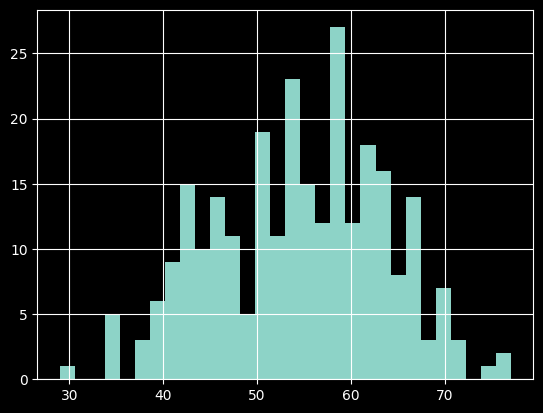

In [251]:
df["Age"].hist(bins=30)

In [252]:
df["Chest pain type"].value_counts()

Chest pain type
4    129
3     79
2     42
1     20
Name: count, dtype: int64

In [253]:
df.groupby("Heart Disease")["Age"].mean()

Heart Disease
Absence     52.706667
Presence    56.591667
Name: Age, dtype: float64

<Axes: xlabel='Heart Disease', ylabel='Age'>

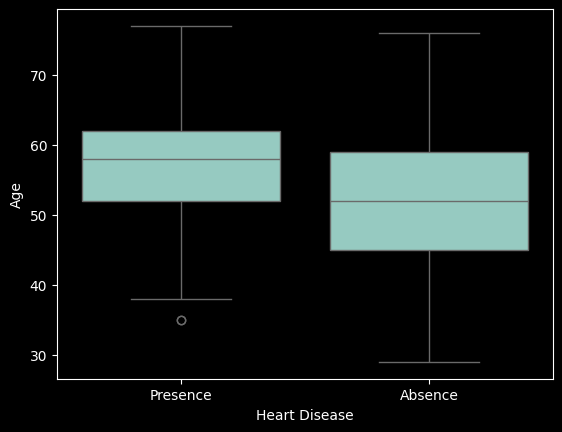

In [254]:
sns.boxplot(x="Heart Disease", y="Age", data=df)

In [255]:
pd.crosstab(df["Exercise angina"], df["Heart Disease"], normalize="index")

Heart Disease,Absence,Presence
Exercise angina,,
0,0.701657,0.298343
1,0.258427,0.741573


<Axes: xlabel='Age', ylabel='Max HR'>

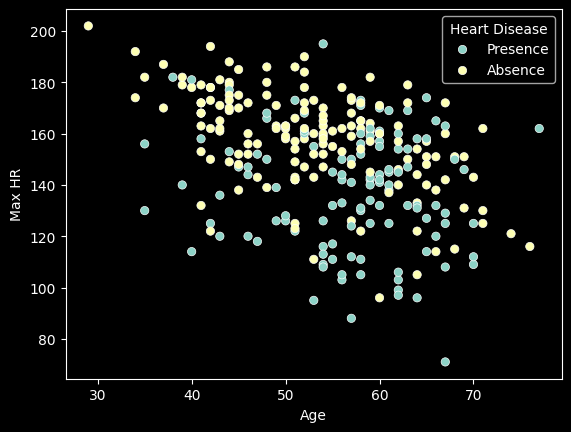

In [256]:
sns.scatterplot(
    x="Age", y="Max HR",
    hue="Heart Disease",
    data=df
)

<Axes: xlabel='Exercise angina', ylabel='ST depression'>

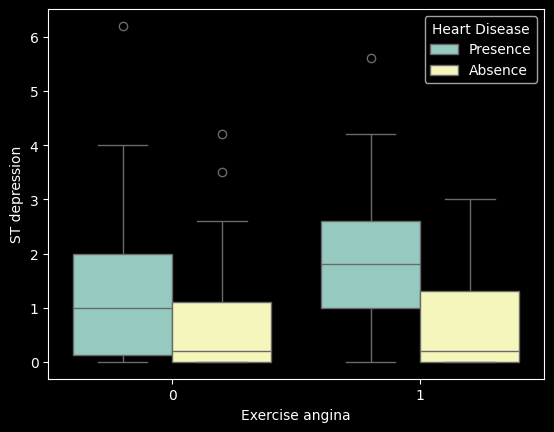

In [257]:
sns.boxplot(
    x="Exercise angina",
    y="ST depression",
    hue="Heart Disease",
    data=df
)


In [258]:
X = df.drop(columns=["Heart Disease"])
y = df["Heart Disease"].map({
    "Absence": 0,
    "Presence": 1
})

cat_cols = ["Sex", "Chest pain type", "FBS over 120", "EKG results", "Exercise angina", "Thallium", "AgeGroup", "CholesterolCategory", "BPCategory"]
num_cols = ["Age", "BP", "Cholesterol", "Max HR", "ST depression", "Slope of ST", "Number of vessels fluro", "RiskScore", "ExerciseAngina x ST_depression", "Age x MaxHR"]

In [259]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [260]:
num_pipeline = make_pipeline(
    SimpleImputer(strategy="median"),
    StandardScaler(),
)

In [261]:
cat_pipeline = make_pipeline(
    SimpleImputer(strategy="most_frequent"),
    OneHotEncoder(),
)

In [262]:
preprocessor = ColumnTransformer([
    ("num", num_pipeline, num_cols),
    ("cat", cat_pipeline, cat_cols)
])

In [263]:
class RiskFeatureEngineer(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self

    def transform(self, X):
        X = X.copy()

        # Age group
        X["AgeGroup"] = pd.cut(
            X["Age"],
            bins=[0, 40, 55, np.inf],
            labels=[0, 1, 2]
        ).astype(int)

        # Cholesterol category
        X["CholesterolCategory"] = pd.cut(
            X["Cholesterol"],
            bins=[0, 200, 240, 1000],
            labels=[0, 1, 2]
        ).astype(int)

        # Blood pressure category
        X["BPCategory"] = pd.cut(
            X["BP"],
            bins=[0, 120, 140, 300],
            labels=[0, 1, 2]
        ).astype(int)

        # Risk score
        X["RiskScore"] = (
            (X["Age"] > 50).astype(int) +
            (X["Cholesterol"] > 240).astype(int) +
            (X["BP"] > 140).astype(int) +
            (X["Exercise angina"] == 1).astype(int)
        )

        # Interactive features
        # ExerciseAngina × ST_depression
        # Age × MaxHR
        X["ExerciseAngina x ST_depression"] = X["Exercise angina"] * X["ST depression"]
        X["Age x MaxHR"] = X["Age"] * X["Max HR"]

        return X


In [270]:
model = make_pipeline(
    RiskFeatureEngineer(),
    preprocessor,
    RandomForestClassifier(class_weight="balanced"),
)

In [271]:
model.fit(X_train, y_train)

,"steps steps: list of tuplesList of (name of step, estimator) tuples that are to be chained insequential order. To be compatible with the scikit-learn API, all stepsmust define `fit`. All non-last steps must also define `transform`. See:ref:`Combining Estimators ` for more details.","[('riskfeatureengineer', ...), ('columntransformer', ...), ...]"
,"transform_input transform_input: list of str, default=NoneThe names of the :term:`metadata` parameters that should be transformed by thepipeline before passing it to the step consuming it.This enables transforming some input arguments to ``fit`` (other than ``X``)to be transformed by the steps of the pipeline up to the step which requiresthem. Requirement is defined via :ref:`metadata routing `.For instance, this can be used to pass a validation set through the pipeline.You can only set this if metadata routing is enabled, which youcan enable using ``sklearn.set_config(enable_metadata_routing=True)``... versionadded:: 1.6",None
,"memory memory: str or object with the joblib.Memory interface, default=NoneUsed to cache the fitted transformers of the pipeline. The last stepwill never be cached, even if it is a transformer. By default, nocaching is performed. If a string is given, it is the path to thecaching directory. Enabling caching triggers a clone of the transformersbefore fitting. Therefore, the transformer instance given to thepipeline cannot be inspected directly. Use the attribute ``named_steps``or ``steps`` to inspect estimators within the pipeline. Caching thetransformers is advantageous when fitting is time consuming. See:ref:`sphx_glr_auto_examples_neighbors_plot_caching_nearest_neighbors.py`for an example on how to enable caching.",None
,"verbose verbose: bool, default=FalseIf True, the time elapsed while fitting each step will be printed as itis completed.",False
,"transformers transformers: list of tuplesList of (name, transformer, columns) tuples specifying thetransformer objects to be applied to subsets of the data.name : str Like in Pipeline and FeatureUnion, this allows the transformer and its parameters to be set using ``set_params`` and searched in grid search.transformer : {'drop', 'passthrough'} or estimator Estimator must support :term:`fit` and :term:`transform`. Special-cased strings 'drop' and 'passthrough' are accepted as well, to indicate to drop the columns or to pass them through untransformed, respectively.columns : str, array-like of str, int, array-like of int, array-like of bool, slice or callable Indexes the data on its second axis. Integers are interpreted as positional columns, while strings can reference DataFrame columns by name. A scalar string or int should be used where ``transformer`` expects X to be a 1d array-like (vector), otherwise a 2d array will be passed to the transformer. A callable is passed the input data `X` and can return any of the above. To select multiple columns by name or dtype, you can use :obj:`make_column_selector`.","[('num', ...), ('cat', ...)]"
,"remainder remainder: {'drop', 'passthrough'} or estimator, default='drop'By default, only the specified columns in `transformers` aretransformed and combined in the output, and the non-specifiedcolumns are dropped. (default of ``'drop'``).By specifying ``remainder='passthrough'``, all remaining columns thatwere not specified in `transformers`, but present in the data passedto `fit` will be automatically passed through. This subset of columnsis concatenated with the output of the transformers. For dataframes,extra columns not seen during `fit` will be excluded from the outputof `transform`.By setting ``remainder`` to be an estimator, the remainingnon-specified columns will use the ``remainder`` estimator. Theestimator must support :term:`fit` and :term:`transform`.Note that using this feature requires that the DataFrame columnsinput at :term:`fit` and :term:`transform` have identical order.",'drop'
,"sparse_threshold sparse_threshold: float, default=0.3If the output of the d

In [286]:
y_proba = model.predict_proba(X_test)[:, 1]
y_pred = (y_proba >= 0.4).astype(int)

# y_pred = model.predict(X_test)


In [287]:
cv_res = cross_val_score(model, X_test, y_test, cv=5)
print(cv_res)
print(cv_res.mean())

[0.81818182 0.90909091 0.72727273 0.81818182 1.        ]
0.8545454545454547


In [288]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.90      0.85      0.88        33
           1       0.78      0.86      0.82        21

    accuracy                           0.85        54
   macro avg       0.84      0.85      0.85        54
weighted avg       0.86      0.85      0.85        54



In [289]:
print(confusion_matrix(y_test, y_pred))

[[28  5]
 [ 3 18]]


In [323]:
import joblib

joblib.dump(model, "heart_disease_predictor.joblib")

['heart_disease_predictor.joblib']